In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import unicodedata


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def remove_special_characters(text):
    """Remove non-alphabetic characters"""
    regex = re.compile(r"[^a-zA-Z\s]")
    return regex.sub(' ', text)


def strip_accents(text):
    """Strip accent characters"""
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if unicodedata.category(c) != 'Mn'
    )

In [ ]:
def clean_text(text):
    text = remove_special_characters(text)
    text = strip_accents(text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [tok for tok in tokens if tok not in stop_words]
    return ' '.join(tokens)

stop_words = set(stopwords.words('english'))

In [ ]:
df = pd.read_csv('English.csv')
df['clean_commentary'] = df['Commentary'].astype(str).apply(clean_text)

## Nodes and graph

In [ ]:
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

In [ ]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')
    text = text.lower()
    tokens = word_tokenize(text)
    return ' '.join(tok for tok in tokens if tok not in stop_words)

df = pd.read_csv("English.csv")
df["clean_commentary"] = df["Commentary"].astype(str).apply(clean_text)

def extract_triples(text):
    doc = nlp(text)
    triples = []
    for sent in doc.sents:
        for token in sent:
            if token.dep_ in ('nsubj', 'nsubjpass'):
                subj = token.text
                verb = token.head.lemma_
                for child in token.head.children:
                    if child.dep_ in ('dobj', 'pobj'):
                        obj = child.text
                        triples.append((subj, verb, obj))
    return triples

df["triples"] = df["clean_commentary"].apply(extract_triples)
df.to_pickle("triples.pkl")


In [ ]:
df[['Chapter', 'Verse', 'triples']].head(10)

,Chapter,Verse,triples
0,1,1,"[(g, read, science), (one, read, bhagavad), (w..."
1,1,2,"[(birth, bereft, vision), (jaya, understand, m..."
2,1,3,"[(point, defect, dro), (adyumna, take, side), ..."
3,1,4,"[(dh, adyumna, obstacle), (fear, mention, vict..."
4,1,8,"[(duryodhana, mention, battle), (hl, ka, kar),..."
5,1,9,"[(others, lie, lives), (account, mention, frie..."
6,1,10,"[(bh, hand, forces), (limited, protect, bh), (..."
7,1,11,"[(duryodhana, praise, prowess), (duryodhana, p..."
8,1,12,"[(compassion, try, cheer), (pains, spared, con..."
9,1,14,"[(conchshell, hand, arjuna), (conchshells, ind..."


In [ ]:
import networkx as nx

G = nx.DiGraph()

for triples in df['triples']:
    for subj, verb, obj in triples:
        # skip meaningless single‑char tokens
        if len(subj) < 2 or len(obj) < 2:
            continue

        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=verb)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 1673 nodes and 3964 edges


In [ ]:
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

# (Optional) Define entity alias mappings to unify synonyms
alias_map = {
    'krishna': 'lord_krishna',
    'arjuna': 'arjuna',
    # add more aliases as needed
}

for triples in df['triples']:
    for subj, verb, obj in triples:
        # Normalize: lowercase and strip spaces
        subj_norm = subj.lower().strip()
        obj_norm  = obj.lower().strip()

        # Map aliases
        subj_norm = alias_map.get(subj_norm, subj_norm)
        obj_norm  = alias_map.get(obj_norm, obj_norm)

        # Skip meaningless tokens (e.g. <2 chars)
        if len(subj_norm) < 2 or len(obj_norm) < 2:
            continue

        # Add nodes and edge
        G.add_node(subj_norm)
        G.add_node(obj_norm)
        G.add_edge(subj_norm, obj_norm, label=verb)

# Summary statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Inspect a sample of edges with labels
print(list(G.edges(data=True))[:10])

Graph has 1673 nodes and 3964 edges
[('one', 'bhagavad', {'label': 'hear'}), ('one', 'lord', {'label': 'hear'}), ('one', 'land', {'label': 'occupy'}), ('one', 'aggressors', {'label': 'consider'}), ('one', 'actions', {'label': 'give'}), ('one', 'activities', {'label': 'sympathize'}), ('one', 'acts', {'label': 'get'}), ('one', 'fire', {'label': 'take'}), ('one', 'person', {'label': 'act'}), ('one', 'opportunity', {'label': 'utilize'})]


## Graph

In [ ]:
#!pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
from rdflib import Graph, Namespace, RDF, RDFS, URIRef, Literal

# Create an RDF graph
g = Graph()

# Define namespace
GITA = Namespace("http://A.org/gita#")
g.bind("gita", GITA)

# Define classes
g.add((GITA.Person, RDF.type, RDFS.Class))
g.add((GITA.Concept, RDF.type, RDFS.Class))
g.add((GITA.Verse, RDF.type, RDFS.Class))

# Define properties (relations)
g.add((GITA.teaches, RDF.type, RDF.Property))
g.add((GITA.teaches, RDFS.domain, GITA.Person))
g.add((GITA.teaches, RDFS.range, GITA.Concept))

g.add((GITA.mentions, RDF.type, RDF.Property))
g.add((GITA.mentions, RDFS.domain, GITA.Verse))
g.add((GITA.mentions, RDFS.range, GITA.Concept))

g.add((GITA.spokenBy, RDF.type, RDF.Property))
g.add((GITA.spokenBy, RDFS.domain, GITA.Verse))
g.add((GITA.spokenBy, RDFS.range, GITA.Person))

# Create instances (people, concepts, verses)
krishna = GITA.Krishna
arjuna = GITA.Arjuna
karma = GITA.Karma
verse_2_47 = GITA.Verse_2_47

# Declare instances
g.add((krishna, RDF.type, GITA.Person))
g.add((arjuna, RDF.type, GITA.Person))
g.add((karma, RDF.type, GITA.Concept))
g.add((verse_2_47, RDF.type, GITA.Verse))

# Add relations
g.add((krishna, GITA.teaches, karma))
g.add((verse_2_47, GITA.spokenBy, krishna))
g.add((verse_2_47, GITA.mentions, karma))

# Print all triples
for s, p, o in g:
    print(s, p, o)


http://A.org/gita#Karma http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://A.org/gita#Concept
http://A.org/gita#Verse_2_47 http://A.org/gita#spokenBy http://A.org/gita#Krishna
http://A.org/gita#Verse_2_47 http://A.org/gita#mentions http://A.org/gita#Karma
http://A.org/gita#Concept http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2000/01/rdf-schema#Class
http://A.org/gita#mentions http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/1999/02/22-rdf-syntax-ns#Property
http://A.org/gita#spokenBy http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/1999/02/22-rdf-syntax-ns#Property
http://A.org/gita#mentions http://www.w3.org/2000/01/rdf-schema#domain http://A.org/gita#Verse
http://A.org/gita#Verse_2_47 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://A.org/gita#Verse
http://A.org/gita#Krishna http://A.org/gita#teaches http://A.org/gita#Karma
http://A.org/gita#Verse http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2000/01

In [ ]:
g.serialize("gita_ontology.rdf", format="xml")  # or 'turtle'

<Graph identifier=N2af8fcdf04f54278955ab98a3606ded0 (<class 'rdflib.graph.Graph'>)>

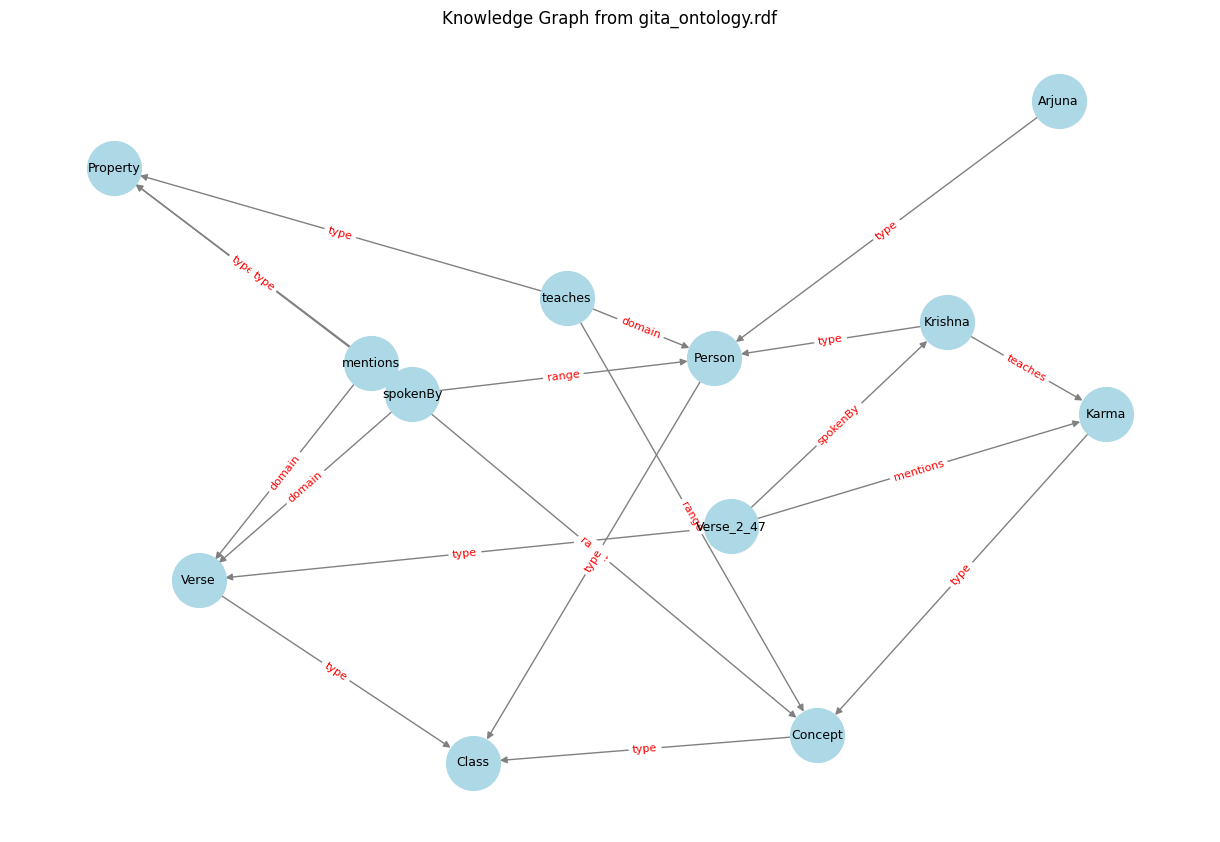

In [ ]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt

# Load your RDF file
g = rdflib.Graph()
g.parse("/content/gita_ontology.rdf", format="xml")  # or 'turtle' for .ttl

# Create a NetworkX graph
G = nx.DiGraph()
for subj, pred, obj in g:
    subj_str = subj.split('#')[-1] if '#' in subj else str(subj)
    pred_str = pred.split('#')[-1] if '#' in pred else str(pred)
    obj_str = obj.split('#')[-1] if '#' in obj else str(obj)
    G.add_edge(subj_str, obj_str, label=pred_str)

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=9, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
plt.title("Knowledge Graph from gita_ontology.rdf")
plt.axis('off')
plt.show()


In [ ]:
nx.write_graphml(G, "gita_ontology.graphml")

##networkx

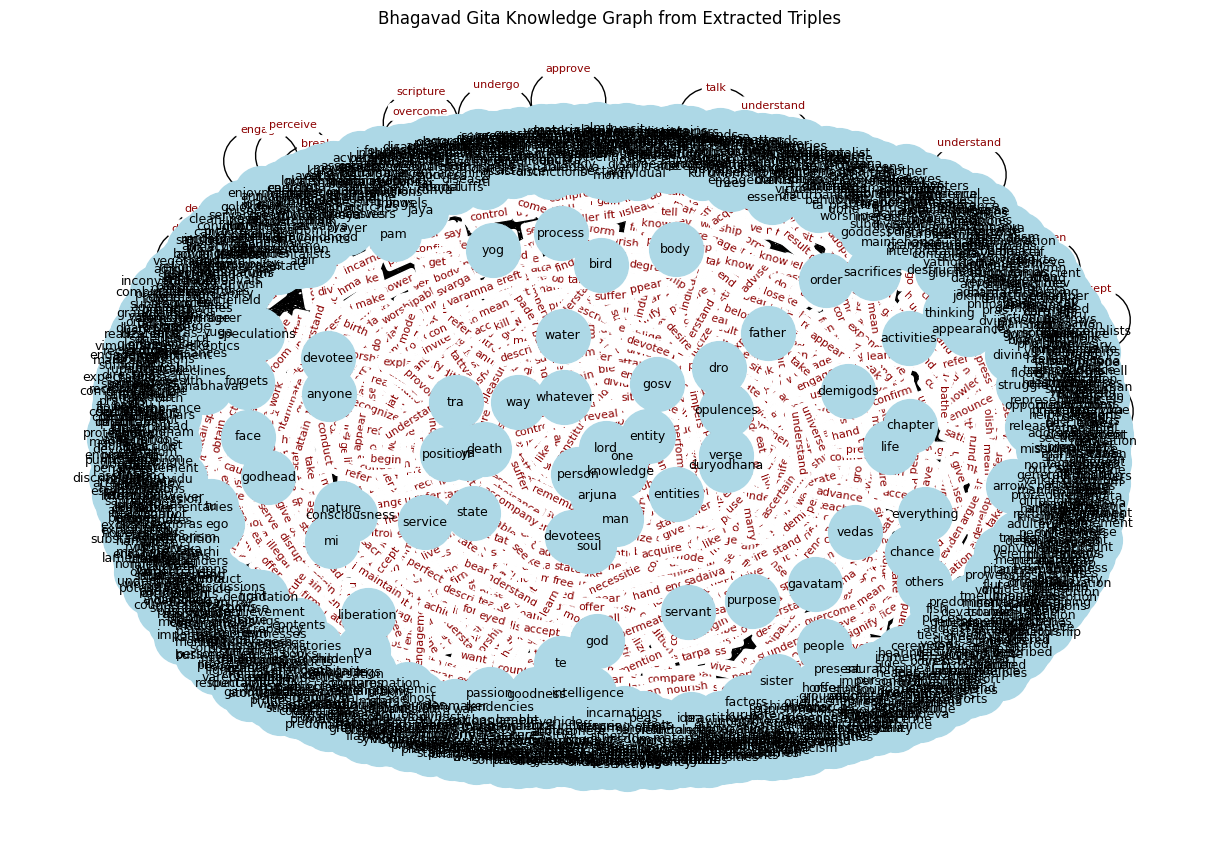

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace

# Load or reuse RDF graph
g = Graph()
GITA = Namespace("http://nx.org/gita#")
g.bind("gita", GITA)

# Add extracted triples from dataframe to RDF graph
for triple_list in df['triples']:
    for subj, verb, obj in triple_list:
        # Filter out short/meaningless tokens
        if len(subj) < 2 or len(obj) < 2:
            continue
        # Add to RDF graph
        g.add((GITA[subj], GITA[verb], GITA[obj]))

# Create NetworkX graph
nxg = nx.DiGraph()

# Convert RDF triples to NetworkX format
for s, p, o in g:
    s_label = s.split("#")[-1]
    p_label = p.split("#")[-1]
    o_label = o.split("#")[-1]
    nxg.add_edge(s_label, o_label, label=p_label)

# Draw the graph
pos = nx.spring_layout(nxg, k=1, iterations=50)
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw(nxg, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=9, arrows=True)
edge_labels = nx.get_edge_attributes(nxg, 'label')
nx.draw_networkx_edge_labels(nxg, pos, edge_labels=edge_labels, font_color='darkred', font_size=8)

plt.title("Bhagavad Gita Knowledge Graph from Extracted Triples")
plt.axis('off')
plt.show()

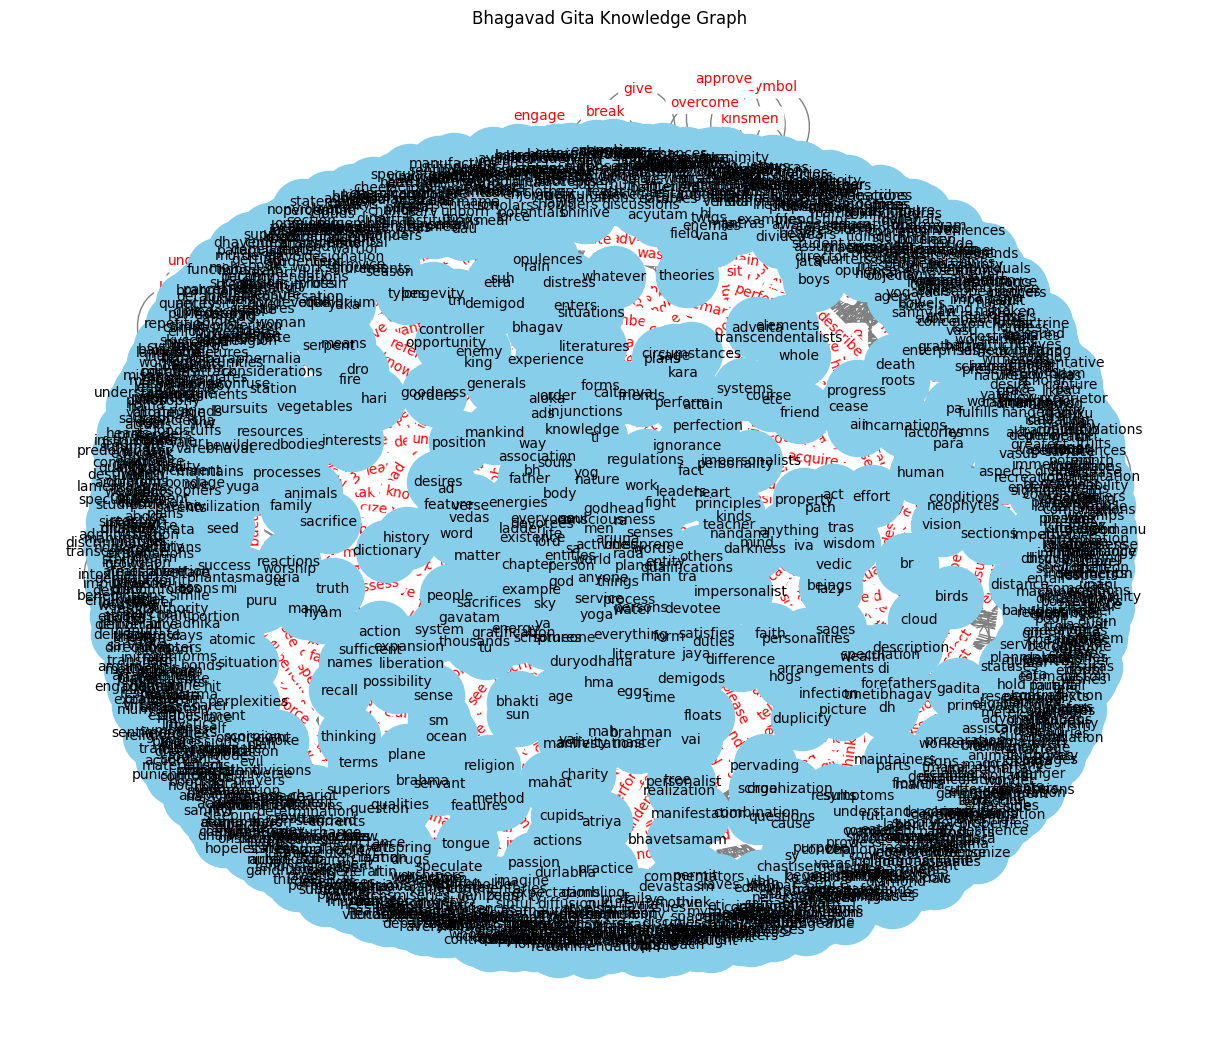

In [ ]:
# Add this to a new or existing notebook
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, URIRef, Literal, RDF

# Load your extracted triples DataFrame from relation extraction
import pandas as pd
df = pd.read_pickle("triples.pkl")  # adjust if you're storing in a different way

# Initialize RDF graph
g = Graph()
GITA = Namespace("http://nxgraph.org/gita#")
g.bind("gita", GITA)

# Add triples to RDF graph
for triple_list in df['triples']:
    for subj, pred, obj in triple_list:
        if len(subj) < 2 or len(obj) < 2: continue
        g.add((GITA[subj], GITA[pred], GITA[obj]))

# Convert to NetworkX for visualization
nxg = nx.DiGraph()
for s, p, o in g:
    s_label = s.split("#")[-1]
    p_label = p.split("#")[-1]
    o_label = o.split("#")[-1]
    nxg.add_edge(s_label, o_label, label=p_label)

# Draw the Knowledge Graph
pos = nx.spring_layout(nxg, k=0.5)
plt.figure(figsize=(12, 10))
nx.draw(nxg, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(nxg, 'label')
nx.draw_networkx_edge_labels(nxg, pos, edge_labels=edge_labels, font_color='red')
plt.title("Bhagavad Gita Knowledge Graph")
plt.show()


## Less congested graph

In [ ]:
from collections import Counter

# Count all triples
triple_counter = Counter()
for triple_list in df['triples']:
    triple_counter.update(triple_list)

# Keep top N most frequent triples
top_triples = [t for t, _ in triple_counter.most_common(100)]  # try 100, or 150

# Create filtered graph
G = nx.DiGraph()
for subj, pred, obj in top_triples:
    G.add_edge(subj, obj, label=pred)


In [ ]:
pos = nx.kamada_kawai_layout(G)  # or try shell_layout, circular_layout


In [ ]:
node_sizes = [G.degree(n) * 150 for n in G.nodes()]
node_colors = ['#add8e6' if G.degree(n) > 3 else '#dddddd' for n in G.nodes()]


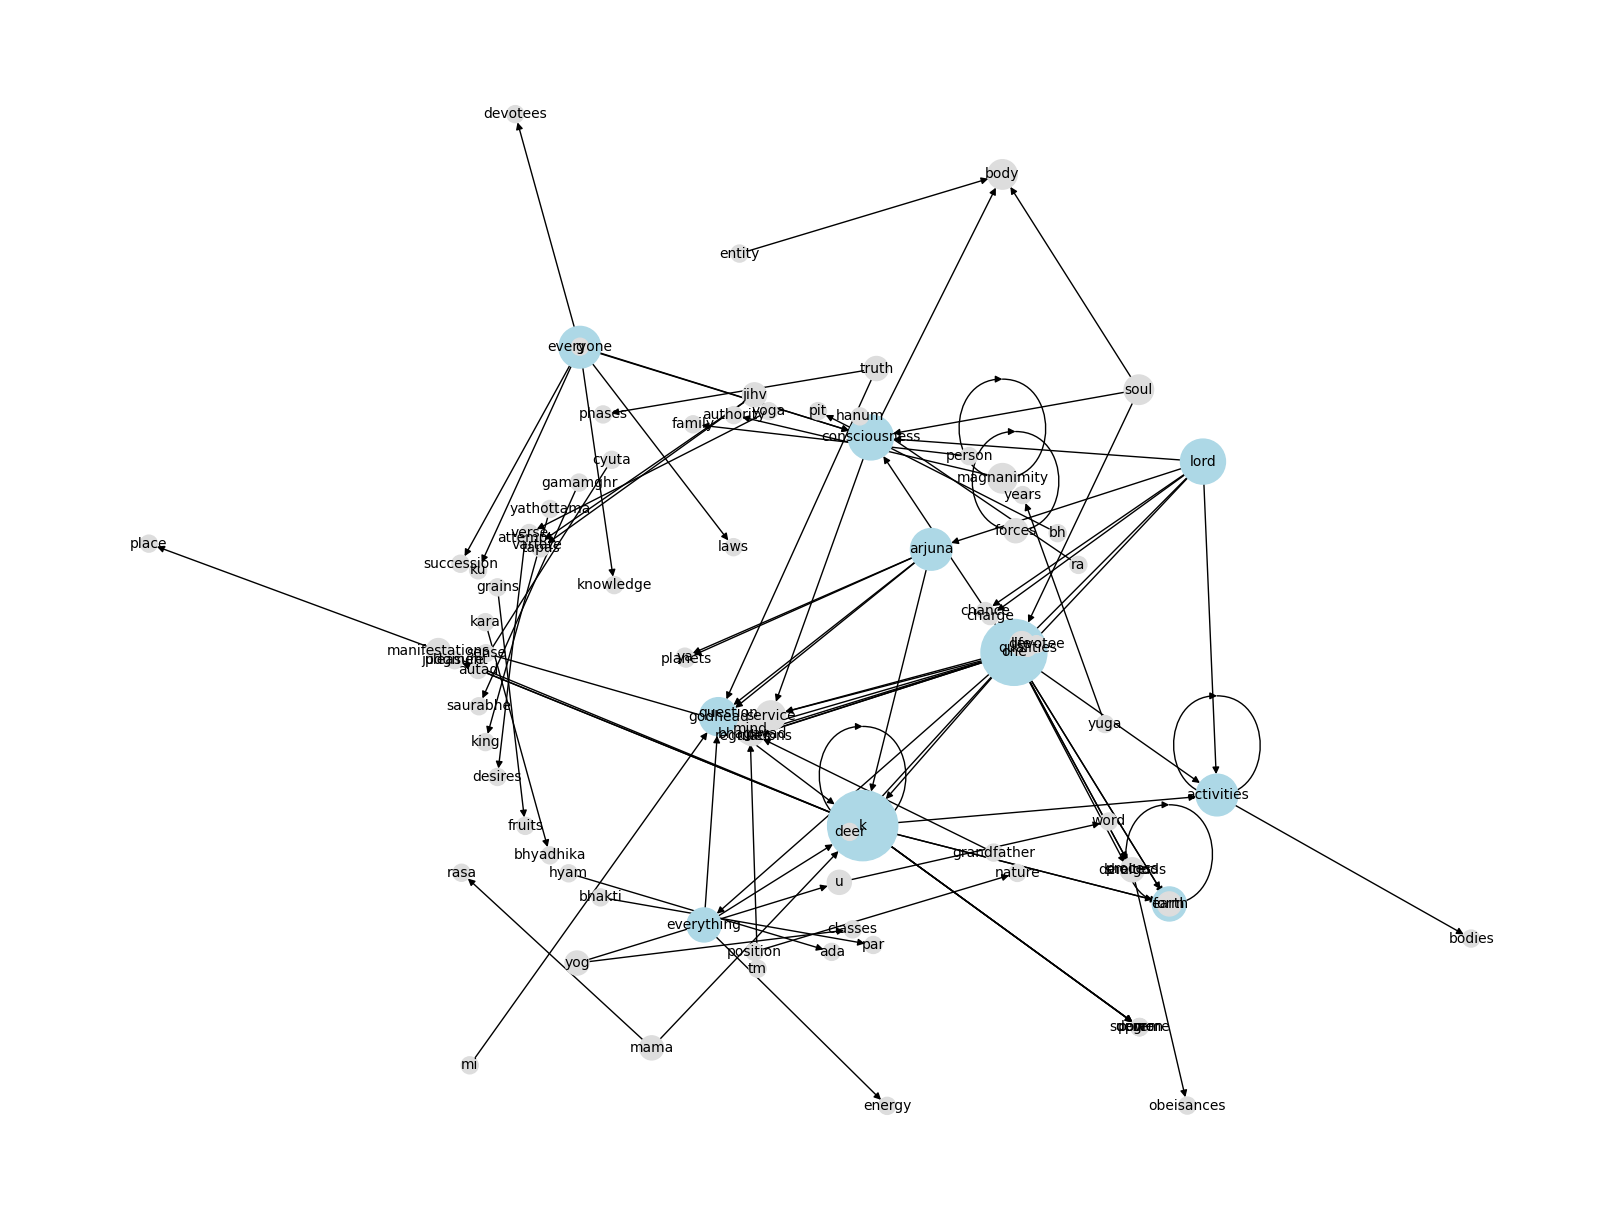

In [ ]:
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10)


## gephi graph

In [ ]:
from collections import Counter

# Count all triples and filter top N
triple_counter = Counter()
for triple_list in df['triples']:
    triple_counter.update(triple_list)

# Keep only top 100 most frequent triples
top_triples = [t for t, _ in triple_counter.most_common(100)]


In [ ]:
pos = nx.kamada_kawai_layout(G)  # more spacing and less node collision


In [ ]:
node_sizes = [G.degree(n) * 200 for n in G.nodes()]


In [ ]:
divine = {'krishna', 'arjuna', 'lord'}
colors = ['lightgreen' if n in divine else 'lightblue' for n in G.nodes()]


In [ ]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources='in_line')  # Fix for Chrome/Safari
# Add nodes and edges
net.from_nx(G)
net.show("interactive_graph.html")


interactive_graph.html


In [ ]:
nx.write_graphml(G, "bhagavad_gita.graphml")


## chapter by chapter

In [ ]:
import networkx as nx

# Group triples by chapter
chapter_graphs = {}

for chapter_num in sorted(df['Chapter'].unique()):
    G = nx.DiGraph()
    chapter_triples = df[df['Chapter'] == chapter_num]['triples']

    for triple_list in chapter_triples:
        for subj, pred, obj in triple_list:
            if len(subj) < 2 or len(obj) < 2:
                continue
            G.add_edge(subj.lower(), obj.lower(), label=pred.lower())

    chapter_graphs[chapter_num] = G
    nx.write_graphml(G, f"chapter_{chapter_num:02d}_gita.graphml")  # Export for Gephi or backup


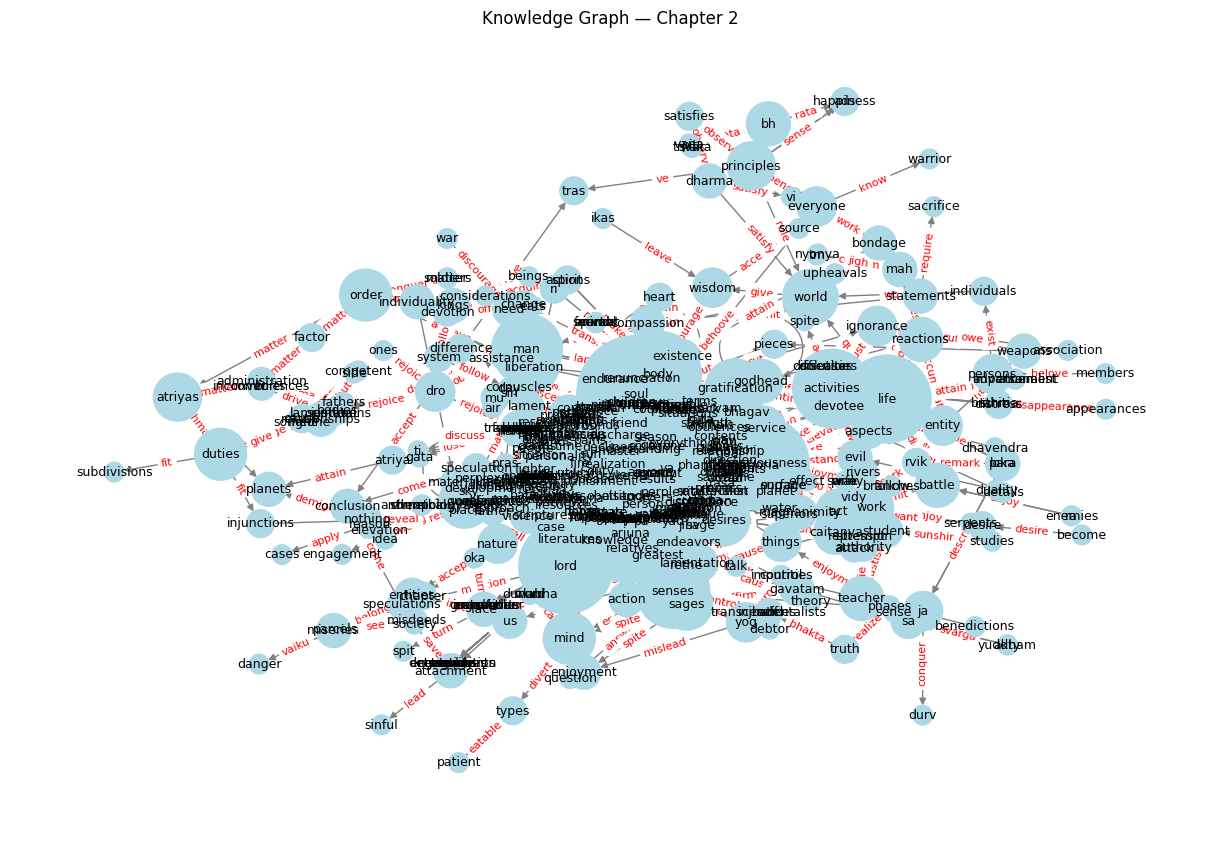

In [ ]:
import matplotlib.pyplot as plt

G = chapter_graphs[2]  # Pick any chapter

pos = nx.kamada_kawai_layout(G)
node_sizes = [G.degree(n) * 200 for n in G.nodes()]
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', font_size=9, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
plt.title("Knowledge Graph — Chapter 2")
plt.axis('off')
plt.show()


## ROGUE EVALUATE

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and 

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=50fad20561f9ac942b0f864ce0e478e222e8bb1b0e7e21b7713150af67079199
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate
import pandas as pd

In [ ]:
rouge = evaluate.load("rouge")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data = {
    "query": [
        "What is the soul?",
        "What is true knowledge?",
        "How to act without desire?"
    ],
    "tfidf_output": [
        "The soul is eternal and never perishes.",
        "True knowledge distinguishes the eternal from the transient.",
        "Act without attachment to results."
    ],
    "bm25_output": [
        "The eternal soul is indestructible and unchanging.",
        "He who sees the imperishable amidst the perishable has true knowledge.",
        "Perform duties without desire for their fruit."
    ],
    "w2v_output": [
        "The soul cannot be cut, burned, or destroyed.",
        "Knowledge dispels ignorance like the sun removes darkness.",
        "Be detached from outcomes and maintain inner peace."
    ],
    "reference": [
        "The soul is indestructible and eternal.",
        "True knowledge is to see the one undivided reality in all beings.",
        "One should act without attachment and stay neutral to success or failure."
    ]
}

In [ ]:
df = pd.DataFrame(data)

In [ ]:
def compute_rouge(row):
    return {
        "rouge_tfidf": rouge.compute(predictions=[row["tfidf_output"]], references=[row["reference"]])["rougeL"],
        "rouge_bm25": rouge.compute(predictions=[row["bm25_output"]], references=[row["reference"]])["rougeL"],
        "rouge_w2v": rouge.compute(predictions=[row["w2v_output"]], references=[row["reference"]])["rougeL"]
    }

In [ ]:
scores = df.apply(compute_rouge, axis=1, result_type="expand")
result = pd.concat([df[["query"]], scores], axis=1)
result


,query,rouge_tfidf,rouge_bm25,rouge_w2v
0,What is the soul?,0.615385,0.769231,0.285714
1,What is true knowledge?,0.300000,0.173913,0.200000
2,How to act without desire?,0.470588,0.105263,0.100000


## Krishna KG

In [ ]:
import pandas as pd

# load the flat triples CSV you generated
df_flat = pd.read_csv("triples.csv")

# see the top 20 most common subjects and objects
print("Top subjects:\n", df_flat['subject'].value_counts().head(20))
print("\nTop objects:\n", df_flat['object'].value_counts().head(20))

Top subjects:
 subject
one              309
k                256
lord             237
arjuna           127
person            99
consciousness     97
soul              66
everything        65
g                 60
activities        55
nature            51
man               50
entity            48
life              47
entities          47
world             45
senses            45
body              43
god               41
service           40
Name: count, dtype: int64

Top objects:
 object
k                144
consciousness    110
activities       110
service           79
life              69
knowledge         66
body              64
one               55
nature            54
godhead           51
lord              48
soul              47
arjuna            43
form              41
world             41
demigods          39
everything        37
senses            36
bhagavad          34
mind              34
Name: count, dtype: int64


In [ ]:
krishna_aliases = {'lord', 'god', 'bhagavad'}

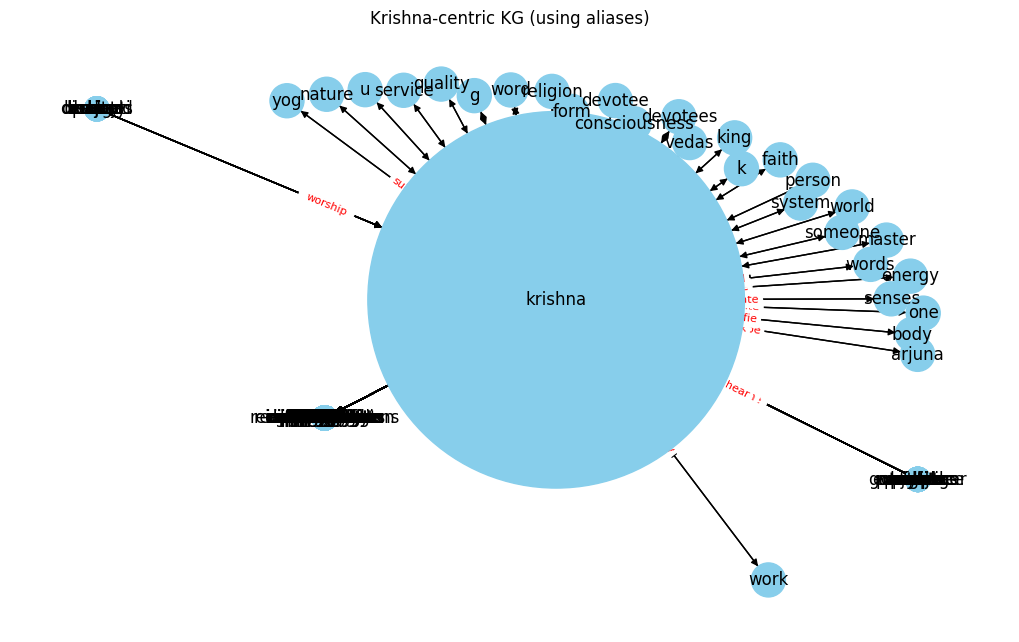

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

mask = (
    df_flat['subject'].str.lower().isin(krishna_aliases) |
    df_flat['object'].str.lower().isin(krishna_aliases)
)
krishna_triples = df_flat[mask]

G = nx.DiGraph()
for subj, pred, obj in krishna_triples.itertuples(index=False):
    s = 'krishna' if subj.lower() in krishna_aliases else subj.lower()
    o = 'krishna' if obj.lower() in krishna_aliases else obj.lower()
    G.add_edge(s, o, label=pred.lower())

plt.figure(figsize=(10,6))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=[G.degree(n)*300 for n in G], node_color='skyblue')
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='red', font_size=8)
plt.title("Krishna‐centric KG (using aliases)")
plt.axis('off')
plt.show()

# and if you want to export for Gephi:
nx.write_graphml(G, "krishna_alias_graph.graphml")

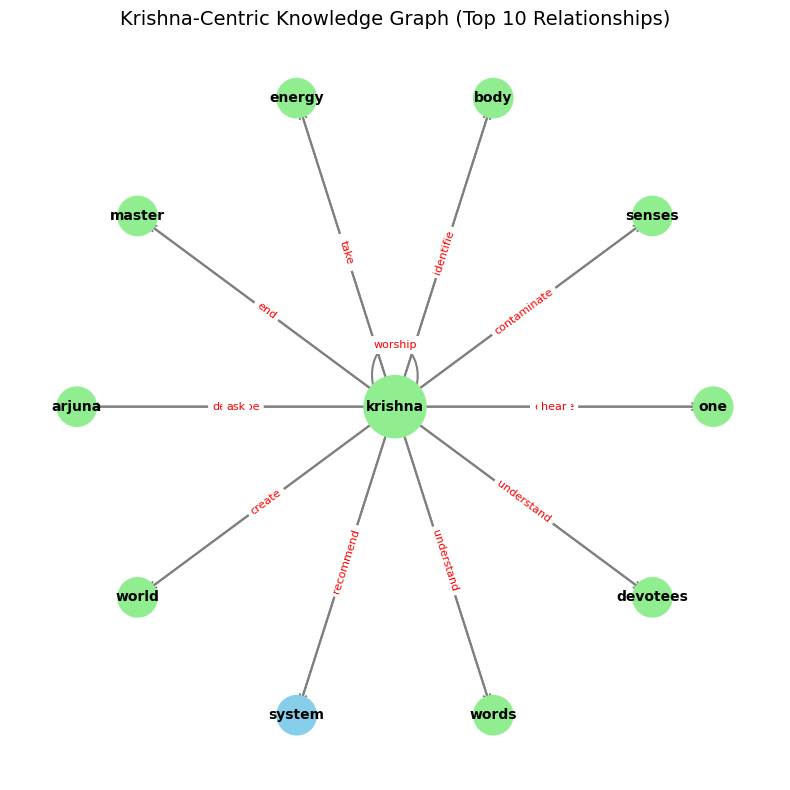

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# --- assume G is your full DiGraph with 'krishna' node --- #

# 1) Find all neighbors of Krishna (both in- and out-)
nbrs = set(G.successors('krishna')) | set(G.predecessors('krishna'))

# 2) Count how often each neighbor appears (edge multiplicity)
cnt = Counter()
for u, v, d in G.edges(data=True):
    if u=='krishna' or v=='krishna':
        cnt[u if u!='krishna' else v] += 1

# 3) Pick top N neighbors
N = 10
top_nbrs = [n for n,_ in cnt.most_common(N)]

# 4) Build a smaller subgraph H
nodes = ['krishna'] + top_nbrs
H = G.subgraph(nodes).copy()

# 5) Star layout: center Krishna at (0,0), neighbors on a circle
angle_step = 2*np.pi / len(top_nbrs)
radius = 1.5
pos = {'krishna': (0,0)}
for i, n in enumerate(top_nbrs):
    theta = i * angle_step
    pos[n] = (radius*np.cos(theta), radius*np.sin(theta))

# 6) Draw H
plt.figure(figsize=(8,8))
# node sizes: center big, neighbors smaller
node_sizes = [2000 if n=='krishna' else 800 for n in H]
nx.draw_networkx_nodes(H, pos,
                       node_size=node_sizes,
                       node_color=['skyblue']+['lightgreen']*len(top_nbrs))
nx.draw_networkx_labels(H, pos,
                        font_size=10,
                        font_weight='bold',
                        verticalalignment='center')

# draw edges and their labels
nx.draw_networkx_edges(H, pos, arrowstyle='->', arrowsize=12, edge_color='gray', width=1.5)
edge_labels = {(u,v):d['label'] for u,v,d in H.edges(data=True)}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Krishna-Centric Knowledge Graph (Top 10 Relationships)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## Arjuna KG

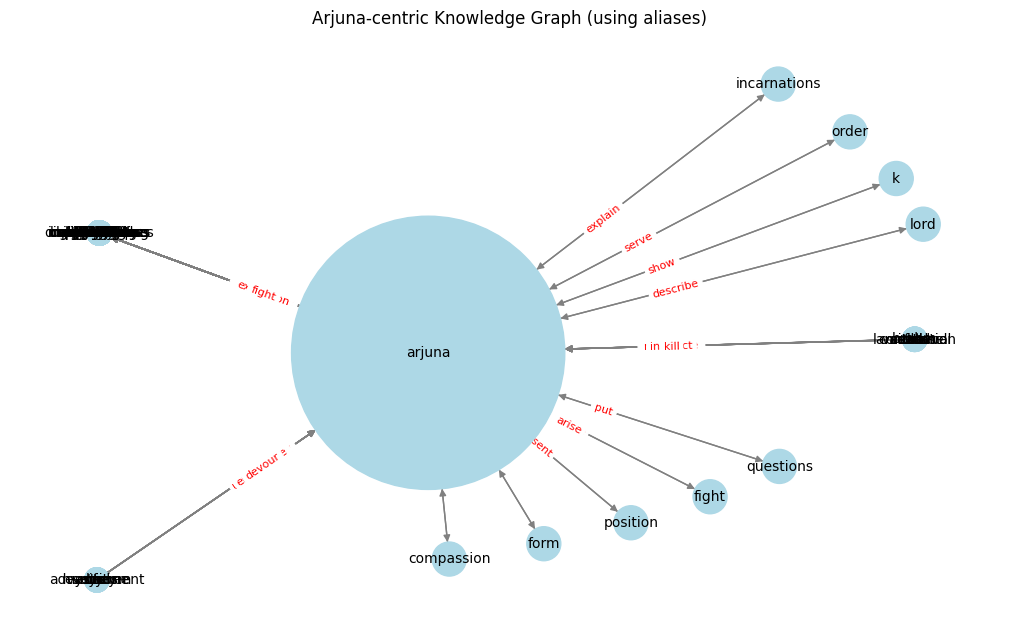

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your flattened triples CSV
df_flat = pd.read_csv("triples.csv")

# 1. Define Arjuna aliases (add more if needed)
arjuna_aliases = {'arjuna', 'partha', 'bharata'}

# 2. Filter triples where subject or object matches any alias
mask = (
    df_flat['subject'].str.lower().isin(arjuna_aliases) |
    df_flat['object'].str.lower().isin(arjuna_aliases)
)
arjuna_triples = df_flat[mask]

# 3. Build the directed graph
G = nx.DiGraph()
for subj, pred, obj in arjuna_triples.itertuples(index=False):
    s = 'arjuna' if subj.lower() in arjuna_aliases else subj.lower()
    o = 'arjuna' if obj.lower() in arjuna_aliases else obj.lower()
    G.add_edge(s, o, label=pred.lower())

# 4. Visualize with Kamada–Kawai layout
plt.figure(figsize=(10, 6))
pos = nx.kamada_kawai_layout(G)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=[G.degree(n) * 300 for n in G.nodes()],
    node_color='lightblue',
    font_size=10,
    edge_color='gray'
)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red',
    font_size=8
)
plt.title("Arjuna-centric Knowledge Graph (using aliases)")
plt.axis('off')
plt.show()

# 5. (Optional) Export for Gephi
nx.write_graphml(G, "arjuna_alias_graph.graphml")

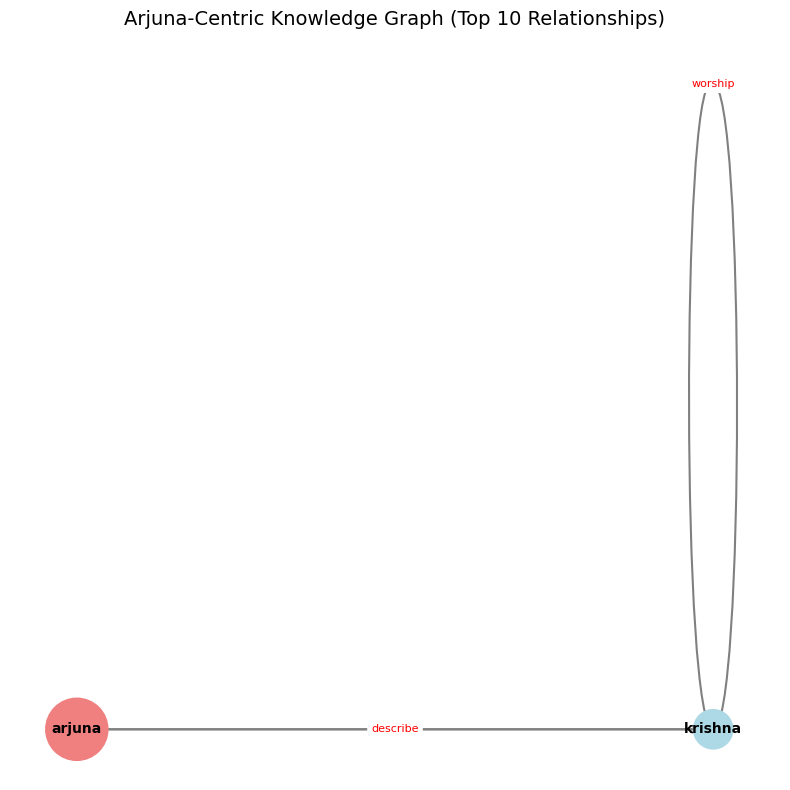

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# --- assume G is your full DiGraph with all triples loaded --- #

center = 'arjuna'

# 1) Find all neighbors of Arjuna (both successors and predecessors)
nbrs = set(G.successors(center)) | set(G.predecessors(center))

# 2) Count how often each neighbor appears in edges with Arjuna
cnt = Counter()
for u, v, d in G.edges(data=True):
    if u == center or v == center:
        other = v if u == center else u
        cnt[other] += 1

# 3) Pick top N neighbors
N = 10
top_nbrs = [n for n,_ in cnt.most_common(N)]

# 4) Build a smaller subgraph H containing Arjuna + those neighbors
nodes = [center] + top_nbrs
H = G.subgraph(nodes).copy()

# 5) Create a star layout: Arjuna at (0,0), neighbors equally around a circle
angle_step = 2 * np.pi / len(top_nbrs)
radius = 1.5
pos = {center: (0, 0)}
for i, n in enumerate(top_nbrs):
    theta = i * angle_step
    pos[n] = (radius * np.cos(theta), radius * np.sin(theta))

# 6) Draw the subgraph
plt.figure(figsize=(8, 8))

# Draw nodes: Arjuna bigger, neighbors smaller
sizes = [2000 if n == center else 800 for n in H.nodes()]
colors = ['lightcoral' if n == center else 'lightblue' for n in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=colors)

# Draw labels
nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')

# Draw directed edges
nx.draw_networkx_edges(H, pos, arrowstyle='->', arrowsize=12, edge_color='gray', width=1.5)

# Draw edge labels (predicates)
edge_labels = {(u, v): d['label'] for u, v, d in H.edges(data=True)}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Arjuna-Centric Knowledge Graph (Top 10 Relationships)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()